In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
nltk.download('punkt')

/home/kiit/Programming-3nd-Year/.venv/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
[nltk_data] Downloading package punkt to /home/kiit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
df = pd.read_csv('CEAS_08.csv')
df.head()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39154 non-null  object
 1   receiver  38692 non-null  object
 2   date      39154 non-null  object
 3   subject   39126 non-null  object
 4   body      39154 non-null  object
 5   label     39154 non-null  int64 
 6   urls      39154 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB


sender        0
receiver    462
date          0
subject      28
body          0
label         0
urls          0
dtype: int64

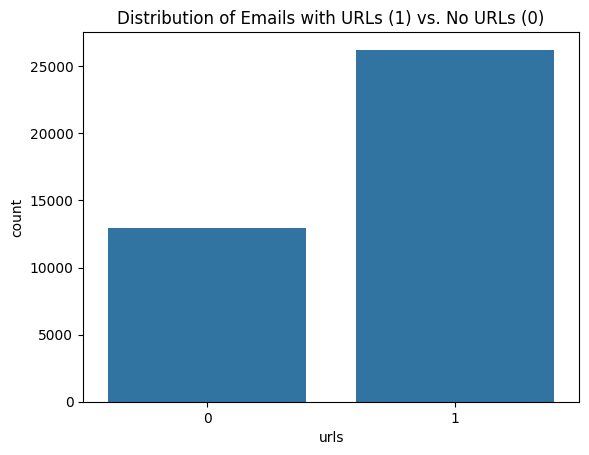

In [9]:
sns.countplot(x='urls', data=df)
plt.title('Distribution of Emails with URLs (1) vs. No URLs (0)')
plt.show()

In [10]:
# Updated function to clean the body text
def clean_email_content_with_links(email_body):
    # Preserve URLs: Using regex to replace URLs with a placeholder
    urls = re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', email_body)
    for i, url in enumerate(urls):
        email_body = email_body.replace(url, f"*URL_{i}*")  # Replace URL with a unique placeholder


    # Remove any non-alphanumeric characters except spaces, and URLs are already preserved
    email_body = re.sub(r'[^a-zA-Z0-9\s*URL_\d*]', '', email_body)

    # Normalize whitespace (remove extra spaces and tabs)
    email_body = re.sub(r'\s+', ' ', email_body).strip()

    return email_body, urls  # Return both the cleaned body and the list of URLs

# Applying the updated cleaning function to the email body column
df['cleaned_body'], df['extracted_urls'] = zip(*df['body'].apply(clean_email_content_with_links))

# Display the first few rows to verify
print(df[['body', 'cleaned_body', 'extracted_urls','label']][918:])
df['extracted_urls'][1972:]

df.head()

                                                    body  \
918    Selon Sébastien Aperghis-Tramoni :\n\n> Leon B...   
919    Enlarged man pole to reach womens G-spots htt...   
920    Basil Chupin wrote:\n>\n> The need to create a...   
921    Hi everyone\n\nI sent this through the other d...   
922    Hello, Leon.\n\n2007/10/2, Leon Brocard :\n> P...   
...                                                  ...   
39149  \n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\n ...   
39150  \n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\n ...   
39151  Hello there ! \nGreat work on the slide show v...   
39152  \nMail from sender , coming from intuit.com\ns...   
39153  Dear fellow Pythonistas!\n\nGuido has accepted...   

                                            cleaned_body  \
918    Selon Sbastien AperghisTramoni Leon Brocard wr...   
919     Enlarged man pole to reach womens Gspots *URL_0*   
920    Basil Chupin wrote The need to create a normal...   
921    Hi everyone I sent this through 

,sender,receiver,date,subject,body,label,urls,cleaned_body,extracted_urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,Buck up your troubles caused by small dimensio...,[http://whitedone.com/]
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,Upgrade your sex and pleasures with these tech...,[http://www.brightmade.com]
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,THE DAILY TOP 10 from CNNcom Top videos and st...,[http://www.cnn.com/video/partners/email/index...
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,Would anyone object to removing so from this l...,[http://en.wikipedia.org/wiki/.so_%28domain_na...
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1,WelcomeFastShippingCustomerSupport *URL_0*,[http://7iwfna.blu.livefilestore.com/y1pXdX3kw...


In [11]:
# 1. Tokenization and Vectorization: TF-IDF Vectorization for the cleaned email bodies
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # You can adjust max_features as needed
X_text = vectorizer.fit_transform(df['cleaned_body']).toarray()

In [12]:
# 2. Feature Engineering

# Feature 1: URLs - Number of URLs present in the email
df['num_urls'] = df['extracted_urls'].apply(len)

# Feature 2: Email Metadata - Extract domain from sender's email address
df['sender_domain'] = df['sender'].apply(lambda x: x.split('@')[-1] if '@' in x else 'unknown')

# Feature 3: Length Features
df['body_length'] = df['cleaned_body'].apply(len)

# 3. Convert categorical email sender domain into numerical representation
df['sender_domain'] = pd.factorize(df['sender_domain'])[0]

In [13]:
from urllib.parse import urlparse

# Function to extract domain from URL
def get_domain_from_url(url):
    try:
        return urlparse(url).netloc
    except:
        return ''



# Function to count special characters in URL
def count_special_chars(url):
    return len(re.findall(r'[@%&\*\$#\?\+\!]', url))

# Function to check if URL is a shortened URL
def is_url_shortened(url):
    shortened_domains = ['bit.ly', 'tinyurl.com', 'goo.gl']  # Known URL shorteners
    domain = get_domain_from_url(url)
    return 1 if any(shortened_domain in domain for shortened_domain in shortened_domains) else 0



# Extracting features for URLs
def extract_url_features(row):
    urls = row['extracted_urls']
    
    # 1. Average URL length
    avg_url_length = sum(len(url) for url in urls) / len(urls) if urls else 0
    
    # 3. Number of special characters in URLs
    num_special_chars = sum(count_special_chars(url) for url in urls)
    
    # 4. Check for URL shortening
    has_url_short = sum(is_url_shortened(url) for url in urls)
    

    # 6. Number of query parameters in URLs
    num_query_params = sum(url.count('?') for url in urls)
    
    # 7. Presence of HTTPS in URLs
    has_https = sum(1 for url in urls if 'https://' in url)
    
    # 8. Frequency of suspicious keywords in URLs
    suspicious_keywords = ['login', 'bank', 'security', 'account', 'verify']
    num_suspicious_keywords = sum(any(keyword in url for keyword in suspicious_keywords) for url in urls)

    return [
        avg_url_length, num_special_chars, 
        has_url_short, num_query_params, 
        has_https, num_suspicious_keywords
    ]



# Apply URL feature extraction to each email
url_features = df.apply(lambda row: extract_url_features(row), axis=1)

# Convert extracted URL features to a DataFrame
url_features_df = pd.DataFrame(url_features.tolist(), columns=[
    'avg_url_length', 'num_special_chars', 
    'has_url_shortener', 'num_query_params', 
    'has_https', 'num_suspicious_keywords_in_urls'            ])

# Combine the URL features with the existing features
X = pd.concat([pd.DataFrame(X_text), df[['num_urls', 'sender_domain', 'body_length']], url_features_df], axis=1)
# Proceed with the rest of the pipeline (train-test split, scaling, etc.)

In [14]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42, stratify=df['label'])

# Standardize numerical features
scaler = StandardScaler()
X_train[['avg_url_length', 'num_special_chars', 'body_length']] = scaler.fit_transform(X_train[['avg_url_length', 'num_special_chars', 'body_length']])
X_test[['avg_url_length', 'num_special_chars', 'body_length']] = scaler.transform(X_test[['avg_url_length', 'num_special_chars', 'body_length']])

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Helps with class imbalance
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

/home/kiit/Programming-3nd-Year/.venv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:45:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[3404   58]
 [  33 4336]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3462
           1       0.99      0.99      0.99      4369

    accuracy                           0.99      7831
   macro avg       0.99      0.99      0.99      7831
weighted avg       0.99      0.99      0.99      7831


ROC-AUC Score: 0.9990844917430047
